In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-12-21 08:26:29--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.36.48.252, 2600:1413:b000:78a::317f, 2600:1413:b000:793::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.36.48.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   239MB/s    in 3.3s    

2022-12-21 08:26:32 (237 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [3]:
source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


In [4]:
root_dir = '/tmp/cats-v-dogs'

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_test_dirs(root_path):
  path = os.path.join(root_path, "training")
  os.makedirs(path)
  path_1 = os.path.join(path, "cats")
  os.makedirs(path_1)
  path_2 = os.path.join(path, "dogs")
  os.makedirs(path_2)
  path = os.path.join(root_path, "testing")
  os.makedirs(path)
  path_3 = os.path.join(path, "cats")
  os.makedirs(path_3)
  path_4 = os.path.join(path, "dogs")
  os.makedirs(path_4)

try:
  create_train_test_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [5]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/testing
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/testing/cats
/tmp/cats-v-dogs/testing/dogs
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs


In [6]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + ' is zero length, so ignoring.')

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]
  
  for filename in training_set:
    src_file = SOURCE + filename
    dest_file = TRAINING + filename
    copyfile(src_file, dest_file)
    
  for filename in testing_set:
    src_file = SOURCE + filename
    dest_file = TESTING + filename
    copyfile(src_file, dest_file)

  pass

In [7]:
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
TESTING_DIR = "/tmp/cats-v-dogs/testing/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
TESTING_CATS_DIR = os.path.join(TESTING_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
TESTING_DOGS_DIR = os.path.join(TESTING_DIR, "dogs/")

if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_CATS_DIR)) > 0:
  for file in os.scandir(TESTING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_DOGS_DIR)) > 0:
  for file in os.scandir(TESTING_DOGS_DIR):
    os.remove(file.path)

split_size = .9

split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

print(f"\n\nThere are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(TESTING_CATS_DIR))} images of cats for testing")
print(f"There are {len(os.listdir(TESTING_DOGS_DIR))} images of dogs for testing")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for testing
There are 1250 images of dogs for testing


In [8]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale=1.0/255.)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=100,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  validation_datagen = ImageDataGenerator(rescale=1.0/255.)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=100,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  return train_generator, validation_generator

In [9]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [10]:
def create_model():
  model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(16,(3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  
  model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy']) 

  return model

In [11]:
model = create_model()

history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
 98/225 [============>.................] - ETA: 39s - loss: 0.7075 - accuracy: 0.5939

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

225/225 [==============================] - 86s 339ms/step - loss: 0.6323 - accuracy: 0.6538 - val_loss: 0.6099 - val_accuracy: 0.6796
Epoch 2/15
225/225 [==============================] - 74s 327ms/step - loss: 0.4940 - accuracy: 0.7596 - val_loss: 0.4725 - val_accuracy: 0.7712
Epoch 3/15
225/225 [==============================] - 74s 327ms/step - loss: 0.4251 - accuracy: 0.8042 - val_loss: 0.4420 - val_accuracy: 0.7908
Epoch 4/15
225/225 [==============================] - 72s 321ms/step - loss: 0.3668 - accuracy: 0.8337 - val_loss: 0.4217 - val_accuracy: 0.8124
Epoch 5/15
225/225 [==============================] - 73s 323ms/step - loss: 0.3041 - accuracy: 0.8681 - val_loss: 0.4482 - val_accuracy: 0.8124
Epoch 6/15
225/225 [==============================] - 73s 325ms/step - loss: 0.2467 - accuracy: 0.8987 - val_loss: 0.4199 - val_accuracy: 0.8236
Epoch 7/15
225/225 [==============================] - 73s 322ms/step - loss: 0.1784 - accuracy: 0.9296 - val_loss: 0.4534 - val_accuracy: 0.8

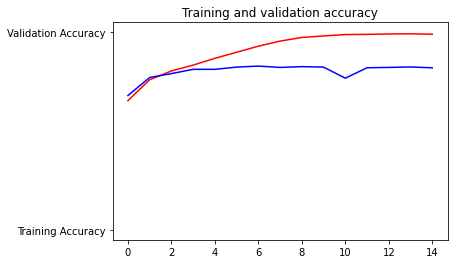

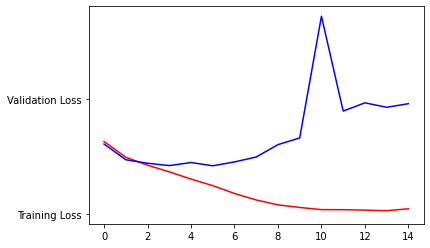

In [12]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) 

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [13]:
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>